### Adicionadas bibliotecas necessárias 

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import pickle

### Abrir o arquivo csv com os serviços classificados pelos pesquisadores 

In [3]:
# Open the file with the data
df = pd.read_csv("servicos_atualizado.csv")
# df = pd.read_csv("servicos_totais.csv")
df.dropna(inplace=True)
df.head()

,id,tags,taken,latitude,longitude,accuracy,secs
0,128886679,baseball hat | city | city view | cliff | hill...,14/4/2006 09:30,0,0,0,"1,2,4,6,10"
1,137155357,dam | hill | hillside | lagoon | lake | mounta...,29/4/2006 17:19,0,0,0,"1,2,11"
2,160198029,army | camouflage | dirt field | field | gun |...,1/1/2004 00:00,0,0,0,"1,9"
3,241150943,building | city | city skyline | city view | f...,11/9/2006 23:26,"-19,950054","-43,908405",140,2
4,241150968,city | hill | hillside | mound | mountain | peak,11/9/2006 23:26,"-19,950054","-43,908405",140,"1,2"


### Para cada tag que foi identificada em todas as imagens a adicionamos em uma lista de tags, que será usada para representar binariamente se ela está presente ou não em cada serviço

In [4]:
# Create a bag of words and a matrix representing if that word is in the text
bag_of_words = set()
for row in df["tags"]:
    for word in row.replace(" ", "").split("|"):
        bag_of_words.add(word)

bag_of_words = list(bag_of_words)
bag_of_words.sort()
len(bag_of_words)

368

### Listamos todos os serviços

In [5]:
# Create a bag of words to represent the classes
classes = set()
for row in df["secs"]:
    for classe in row.replace(" ", "").split(","):
        classes.add(int(classe))

classes = list(classes)
classes.sort()
classes = [str(classe) for classe in classes]
classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [6]:
# Create a matrix where each row is a text and each column is a word
matrix = []
for row in df["tags"]:
    matrix.append([1 if word in row.replace(" ", "").split("|") else 0 for word in bag_of_words])

matrix = np.array(matrix)

In [7]:
matrix.shape

(249, 368)

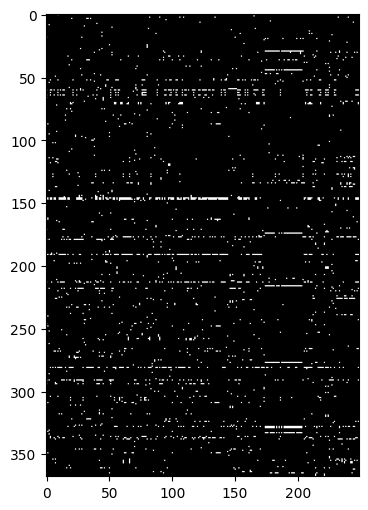

In [8]:
# Vizualize the matrix as a image
import matplotlib.pyplot as plt
# Size of the image 10x10
plt.figure(figsize=(6,6))
plt.imshow(matrix.T, cmap='gray')
plt.show()

In [9]:
servicos = []
for row in df["secs"]:
    servicos.append([1 if classe in row.replace(" ", "").split(",") else 0 for classe in classes])

servicos = np.array(servicos)
servicos.shape
servicos

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [10]:
soma = np.zeros(len(servicos[0]))
for i in range(len(servicos)):
    soma += servicos[i]

soma

array([115.,  78.,  63.,  19.,  15.,  17.,  12.,  10.,  10.,   9.,  18.,
        10.])

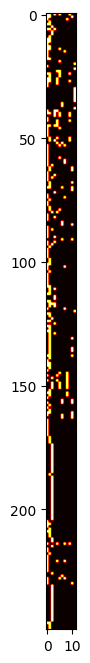

In [157]:
# Size of the image 10x10
plt.figure(figsize=(8,8))
plt.imshow(servicos, cmap='hot')
plt.show()

In [158]:
# Split the data in train and test
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
import tqdm
random_state = 32

for random_state in tqdm.tqdm(range(0, 100)):
    for i in tqdm.tqdm(range(0, 10)):
        X_train, X_test, y_train, y_test = train_test_split(matrix, servicos, test_size=0.33, random_state=random_state)
        randon_forest = MultiOutputClassifier(RandomForestClassifier(n_estimators=100)).fit(X_train,y_train)

        # Predict the test data
        y_pred = randon_forest.predict(X_test)

        score = randon_forest.score(X_test, y_test)

        acc = []
        for i in range(0, len(classes)):
            acc.append(accuracy_score(y_test[:,i], y_pred[:,i]))

        # Save the version of the model as a run with a version number and its score
        import os

        if not os.path.exists(f"models_{random_state}"):
            os.mkdir(f"models_{random_state}")

        # Save the model, the data and the confusion matrix
        if not os.path.exists(f"models_{random_state}/run_{score:.4f}"):
            os.mkdir(f"models_{random_state}/run_{score:.4f}")
            
        pickle.dump(randon_forest, open(f"models_{random_state}/run_{score:.4f}/modelo.sav", 'wb'))
        pickle.dump(bag_of_words, open(f"models_{random_state}/run_{score:.4f}/bag_of_words.sav", 'wb'))
        pickle.dump(classes, open(f"models_{random_state}/run_{score:.4f}/classes.sav", 'wb'))
        pickle.dump(y_test, open(f"models_{random_state}/run_{score:.4f}/y_test.sav", 'wb'))
        pickle.dump(y_train, open(f"models_{random_state}/run_{score:.4f}/y_train.sav", 'wb'))
        pickle.dump(X_test, open(f"models_{random_state}/run_{score:.4f}/X_test.sav", 'wb'))
        pickle.dump(X_train, open(f"models_{random_state}/run_{score:.4f}/X_train.sav", 'wb'))
        pickle.dump(acc, open(f"models_{random_state}/run_{score:.4f}/acc.sav", 'wb'))
        print(score)

  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [5]:
# Get the best model for each random state
import os
import pickle
import numpy as np
# Check if the data is the same in all the models

list_dir = os.listdir()
for dir in list_dir:
    if dir.startswith("models_0"):
        # Get the best model
        best_model = None
        best_score = 0
        for run in os.listdir(dir):
            score = float(run.split("_")[1])
            if score > best_score:
                best_score = score
                best_model = run
        
        # Open the model and the data
        model = pickle.load(open(f"{dir}/{best_model}/modelo.sav", 'rb'))
        bag_of_words = pickle.load(open(f"{dir}/{best_model}/bag_of_words.sav", 'rb'))
        classes = pickle.load(open(f"{dir}/{best_model}/classes.sav", 'rb'))
        y_test = pickle.load(open(f"{dir}/{best_model}/y_test.sav", 'rb'))
        y_train = pickle.load(open(f"{dir}/{best_model}/y_train.sav", 'rb'))
        X_test = pickle.load(open(f"{dir}/{best_model}/X_test.sav", 'rb'))
        X_train = pickle.load(open(f"{dir}/{best_model}/X_train.sav", 'rb'))
        acc = pickle.load(open(f"{dir}/{best_model}/acc.sav", 'rb'))
        y_pred = model.predict(X_test)

acc
                        

[0.8313253012048193,
 0.9036144578313253,
 0.927710843373494,
 0.963855421686747,
 0.9397590361445783,
 0.9518072289156626,
 0.9759036144578314,
 0.963855421686747,
 0.9759036144578314,
 0.9879518072289156,
 0.9879518072289156,
 0.9879518072289156]

In [6]:
score

0.5422

In [7]:
soma = np.zeros(len(y_train[0]))
for i in range(len(y_train)):
    soma += y_train[i]

soma

array([73., 54., 42., 12.,  9., 14.,  8.,  5.,  7.,  8., 12.,  8.])

In [8]:
soma = np.zeros(len(y_test[0]))
for i in range(len(y_test)):
    soma += y_test[i]

soma

array([42., 24., 21.,  7.,  6.,  3.,  4.,  5.,  3.,  1.,  6.,  2.])

In [9]:
# Calculate the accuracy
from sklearn.metrics import accuracy_score
for i in range(0, len(classes)):
    print(classes[i], accuracy_score(y_test[:,i], y_pred[:,i]))

1 0.8313253012048193
2 0.9036144578313253
3 0.927710843373494
4 0.963855421686747
5 0.9397590361445783
6 0.9518072289156626
7 0.9759036144578314
8 0.963855421686747
9 0.9759036144578314
10 0.9879518072289156
11 0.9879518072289156
12 0.9879518072289156


In [ ]:
# Save the models
pickle.dump(randon_forest, open("randon_forest.pkl", "wb"))
pickle.dump(bag_of_words, open("bag_of_words.pkl", "wb"))
pickle.dump(classes, open("classes.pkl", "wb"))

In [13]:
import pandas as pd
important_words = pd.DataFrame()
randon_forest = model
for i in range(0, len(classes)):
    # Feature importance in the model
    importances = randon_forest.estimators_[i].feature_importances_
    std = np.std([tree.feature_importances_ for tree in randon_forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print("%s) " % classes[i], end=" ")
    # Print the feature ranking
    important_words[str(i+1)] = pd.Series([bag_of_words[indices[f]] for f in range(0, 15)])
    important_words[str(i+1) + "_importace"] = pd.Series([ importances[indices[f]]  for f in range(0, 15)])

important_words.to_csv("important_words.csv", index=False, sep=";")

1)  2)  3)  4)  5)  6)  7)  8)  9)  10)  11)  12)  

In [14]:
#  Columns =["id", "model_identified_tags"])
serra_null_gps = pd.read_csv("serra_tags_null_gps.csv", sep=";")
serra_null_gps = serra_null_gps[["id", "model_identified_tags"]]
serra_null_gps

,id,model_identified_tags
0,52904733325,barrel | basement | beam | ceiling | container...
1,9241659630,balustrade | city | city view | hill | hillsid...
2,15187099604,bird | branch | brown | log | peak | perch | p...
3,2123658330,blanket | cloud | cloudy | green | hill | hill...
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...
...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...
3083,4793139481,backdrop | building | city | city skyline | ci...
3084,51131866624,blue | bud | floor | flower | grass | grow | p...
3085,15787763770,bloom | flower | grow | pink | plant | tree


In [15]:
# Create a matrix where each row is a text and each column is a word
null_tags = []
for row in serra_null_gps["model_identified_tags"]:
    null_tags.append([1 if word in row.replace(" ", "").split("|") else 0 for word in bag_of_words])

null_tags = np.array(null_tags)
results = randon_forest.predict(null_tags)
results

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [16]:
# Sum of each class
soma = np.zeros(len(results[0]))
for i in range(len(results)):
    soma += results[i]

soma

array([1056.,  683.,  989.,   48.,   44.,   54.,   19.,    7.,   11.,
         16.,   42.,   10.])

In [17]:
# Turn the results into a dataframe and join with the original dataframe
results_df = pd.DataFrame(results, columns=classes)
results_df = pd.concat([serra_null_gps, results_df], axis=1)
results_df

,id,model_identified_tags,1,2,3,4,5,6,7,8,9,10,11,12
0,52904733325,barrel | basement | beam | ceiling | container...,0,0,0,0,0,0,0,0,0,0,0,0
1,9241659630,balustrade | city | city view | hill | hillsid...,1,1,0,0,0,0,0,0,0,0,0,0
2,15187099604,bird | branch | brown | log | peak | perch | p...,0,0,1,0,0,0,0,0,0,0,0,0
3,2123658330,blanket | cloud | cloudy | green | hill | hill...,1,0,0,0,0,0,0,0,0,0,0,0
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...,0,0,1,0,0,0,0,0,0,0,0,0
3083,4793139481,backdrop | building | city | city skyline | ci...,1,0,0,0,0,0,0,0,0,0,0,0
3084,51131866624,blue | bud | floor | flower | grass | grow | p...,0,0,1,0,0,0,0,0,0,0,0,0
3085,15787763770,bloom | flower | grow | pink | plant | tree,0,0,1,0,0,0,0,0,0,0,0,0


In [18]:
# Predicted classes 
results_df["predicted_classes"] = results_df.apply(lambda row: ",".join([classes[i] for i in range(0, len(classes)) if row[classes[i]] == 1]), axis=1)
results_df

,id,model_identified_tags,1,2,3,4,5,6,7,8,9,10,11,12,predicted_classes
0,52904733325,barrel | basement | beam | ceiling | container...,0,0,0,0,0,0,0,0,0,0,0,0,
1,9241659630,balustrade | city | city view | hill | hillsid...,1,1,0,0,0,0,0,0,0,0,0,0,"1,2"
2,15187099604,bird | branch | brown | log | peak | perch | p...,0,0,1,0,0,0,0,0,0,0,0,0,3
3,2123658330,blanket | cloud | cloudy | green | hill | hill...,1,0,0,0,0,0,0,0,0,0,0,0,1
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...,0,0,0,0,0,0,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...,0,0,1,0,0,0,0,0,0,0,0,0,3
3083,4793139481,backdrop | building | city | city skyline | ci...,1,0,0,0,0,0,0,0,0,0,0,0,1
3084,51131866624,blue | bud | floor | flower | grass | grow | p...,0,0,1,0,0,0,0,0,0,0,0,0,3
3085,15787763770,bloom | flower | grow | pink | plant | tree,0,0,1,0,0,0,0,0,0,0,0,0,3


In [19]:
results_df.to_csv("results_predicted.csv", sep=";", index=False)

In [173]:
results_df = pd.read_csv("results_predicted.csv", sep=";")
results_df

,id,model_identified_tags,1,2,3,4,5,6,7,8,9,10,11,12,predicted_classes
0,52904733325,barrel | basement | beam | ceiling | container...,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,9241659630,balustrade | city | city view | hill | hillsid...,1,1,0,0,0,0,0,0,0,0,0,0,"1,2"
2,15187099604,bird | branch | brown | log | peak | perch | p...,0,0,1,0,0,0,0,0,0,0,0,0,3
3,2123658330,blanket | cloud | cloudy | green | hill | hill...,1,0,0,0,0,0,0,0,0,0,0,0,1
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...,0,0,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...,0,0,1,0,0,0,0,0,0,0,0,0,3
3083,4793139481,backdrop | building | city | city skyline | ci...,1,0,0,0,0,0,0,0,0,0,0,0,1
3084,51131866624,blue | bud | floor | flower | grass | grow | p...,0,0,1,0,0,0,0,0,0,0,0,0,3
3085,15787763770,bloom | flower | grow | pink | plant | tree,0,0,1,0,0,0,0,0,0,0,0,0,3


In [174]:
results_df["predicted_classes"].isnull().sum()

737

In [ ]:
# sum of the predicted classes 1 to 12
soma = np.zeros(len(classes))
for i in range(len(results_df)):
    soma += results_df.iloc[i][classes].values

soma

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('O') to dtype('float64') with casting rule 'same_kind'

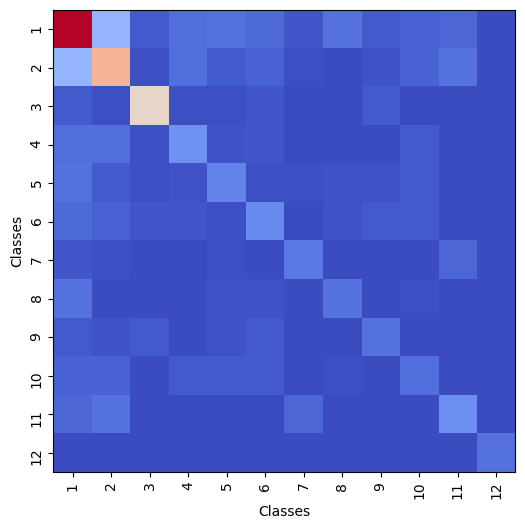

In [ ]:
# For each row in servicos, count the number of interactions between the classes
interacao = np.zeros((servicos.shape[1], servicos.shape[1]))
for row in servicos:
    for i in range(len(row)):
        for j in range(len(row)):
            if row[i] == 1 and row[j] == 1:
                interacao[i][j] += 1

plt.figure(figsize=(6,6))
plt.xlabel("Classes")
plt.xticks(range(len(classes)), classes, rotation=90)
plt.ylabel("Classes")
plt.yticks(range(len(classes)), classes, rotation=90)
plt.imshow(interacao, cmap='coolwarm')
plt.show()

In [ ]:
# Get diagonal from interacao
diagonal = np.array([interacao[i][i] for i in range(len(interacao))])
diagonal

array([115.,  78.,  63.,  19.,  15.,  17.,  12.,  10.,  10.,   9.,  18.,
        10.])

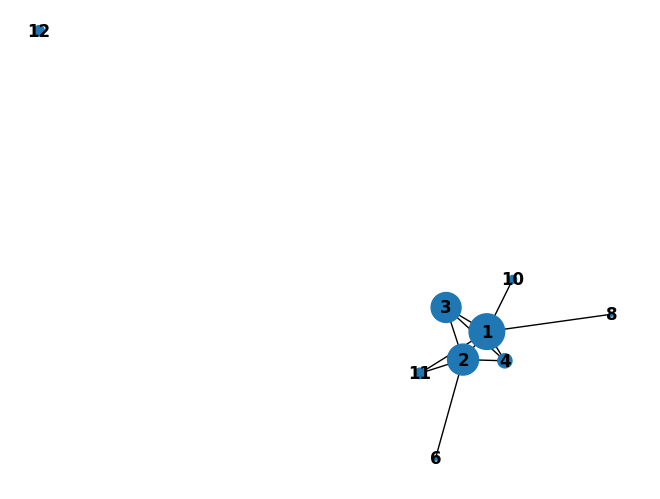

In [ ]:
import networkx as nx

np.fill_diagonal(interacao, 0)
G = nx.from_numpy_array(interacao)

# Relable the nodes to the classes names
mapping = {i:classes[i] for i in range(len(classes))}
G = nx.relabel_nodes(G, mapping)
nx.draw(G, with_labels=True, font_weight='bold', node_size=diagonal*8)

